In [1]:
import numpy as np
from geometricus import GeometricusEmbedding, MomentType, MomentInvariants
import prody as pd
from umap import UMAP
from pathlib import Path
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import networkx as nx
from cath_utils import cath
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2


In [10]:
pdb_folder = "./ecod_zern/domains/"
invariants1 = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.KMER,
                                        size=30)
print("invariants1 extracted")
invariants2 = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.RADIUS_UPSAMPLE,
                                              size=10)
print("invariants2 extracted")

invariants = {k: cath.MomentInvariantsSavable.from_invariant(cath.concat_invariants(v, invariants2[k])) for k, v in invariants1.items()}

invariants1 extracted
invariants2 extracted


In [2]:
import pickle
invariants = pickle.load(open("ecod_invariants.pkl", "rb"))

In [11]:
# import pickle
# pickle.dump(invariants, open("ecod_invariants.pkl", "wb"))
single_invariant = invariants[list(invariants.keys())[0]]

In [12]:
domain_info = cath.EcodInfo.from_ecod_class_file().ecod_classification

In [150]:
mappings = {f"{k}.pdbnum.pdb": f"{v.f_id}" for k, v in domain_info.items() if f"{k}.pdbnum.pdb" in invariants}
keys, counts = np.unique(list(mappings.values()), return_counts=True)
least_allowed_class_count = 2
keys_to_use = {x for x in keys[np.where(counts >= least_allowed_class_count)[0]]}
mappings = {k: v for k, v in mappings.items() if v in keys_to_use}
len(keys_to_use), len(mappings)

(34, 755)

In [20]:
train_data, test_data = cath.transform_geometricus_dataset_for_training(mappings,
                                                                        invariants, batch_no=256)

In [16]:
model = torch.load("./embedder.pth")
model.eval()

GCN(
  (conv1): GraphConv(32, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (lin): Linear(in_features=128, out_features=116, bias=True)
)

In [27]:
def get_embedding(loaders, model):
    model.eval()
    res = list()
    labels = []
    predicted_labels = []
    for loader in loaders:
        for data in loader:
            data = data.cuda()
            out = model(data.x, data.edge_index, data.batch)
            res.append(out.cpu().detach().numpy())
            labels.append(data.y.cpu().detach().numpy())
            predicted_labels.append(out.argmax(dim=1).cpu().detach().numpy())
    return np.concatenate(res), np.concatenate(labels), np.concatenate(predicted_labels)

In [28]:
pytorch_embedding, labels, pred = get_embedding([train_data, test_data], model)
pytorch_embedding.shape, labels.shape, pred.shape

((755, 116), (755,), (755,))

In [53]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [69]:
import umap
reducer = umap.UMAP(n_components=2, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

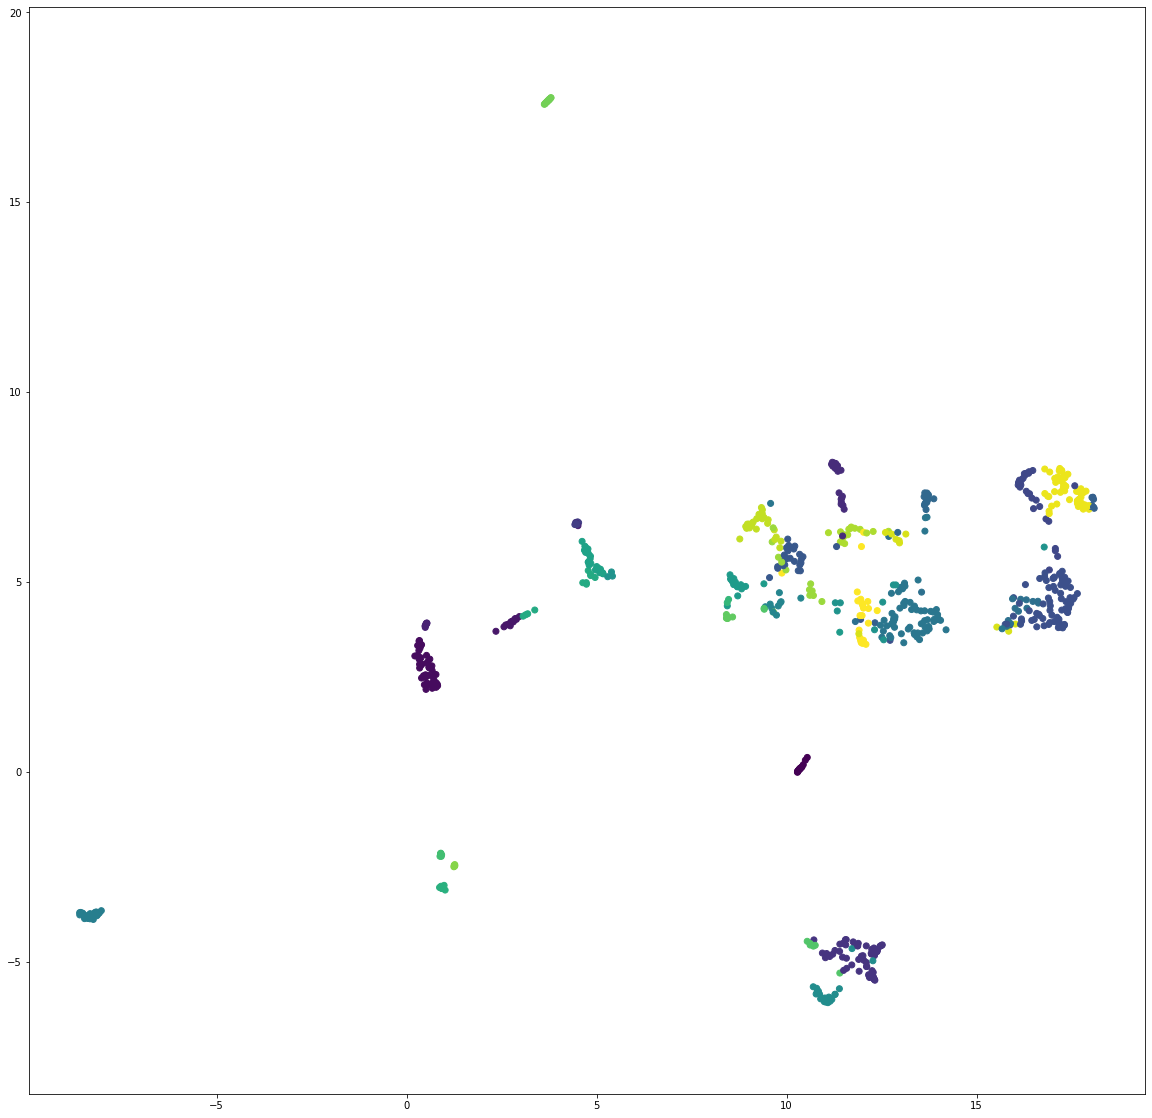

In [70]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

In [71]:
true_ecod, pred_ecod = list(), list()
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            true_ecod.append(1)
        else:
            true_ecod.append(0)

In [72]:
pred_ecod = metrics.pairwise_distances(embedding).flatten()
pred_ecod = pred_ecod.max() - pred_ecod

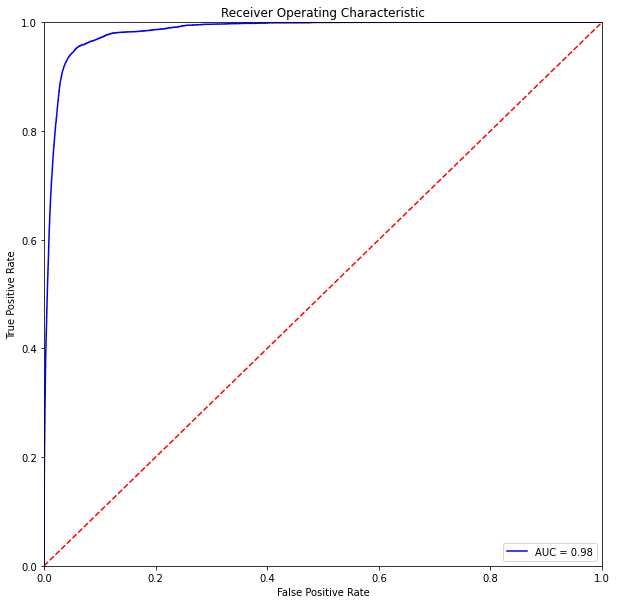

In [73]:
fpr, tpr, threshold = metrics.roc_curve(true_ecod, pred_ecod)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [79]:
single_invariants = cath.invariants_from_pdb_folder(pdb_folder, split_type=cath.SplitType.KMER,
                                        size=15)

/mnt/backup2/geometric/geo_env/lib/python3.8/site-packages/geometricus/geometricus.py:698: RuntimeWarning: invalid value encountered in log1p
  for x in (np.log1p(invariants[key].moments) * resolution).astype(int)


(761, 59)

In [109]:
embedder = GeometricusEmbedding.from_invariants([x for x in single_invariants.values()], resolution=.25)
embedder.embedding.shape

/mnt/backup2/geometric/geo_env/lib/python3.8/site-packages/geometricus/geometricus.py:698: RuntimeWarning: invalid value encountered in log1p
  for x in (np.log1p(invariants[key].moments) * resolution).astype(int)


(761, 76)

In [143]:
reducer = umap.UMAP(n_components=10, metric="braycurtis")
embedding = reducer.fit_transform(embedder.embedding)

In [144]:
labels = embedder.protein_keys

In [145]:
embedding = [embedding[i] for i, x in enumerate(labels) if x+".pdb" in mappings]
labels = [mappings[x+".pdb"] for i, x in enumerate(labels) if x+".pdb" in mappings]

In [146]:
true_ecod, pred_ecod = list(), list()
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            true_ecod.append(1)
        else:
            true_ecod.append(0)

In [147]:
pred_ecod = metrics.pairwise_distances(embedding).flatten()
pred_ecod = pred_ecod.max() - pred_ecod

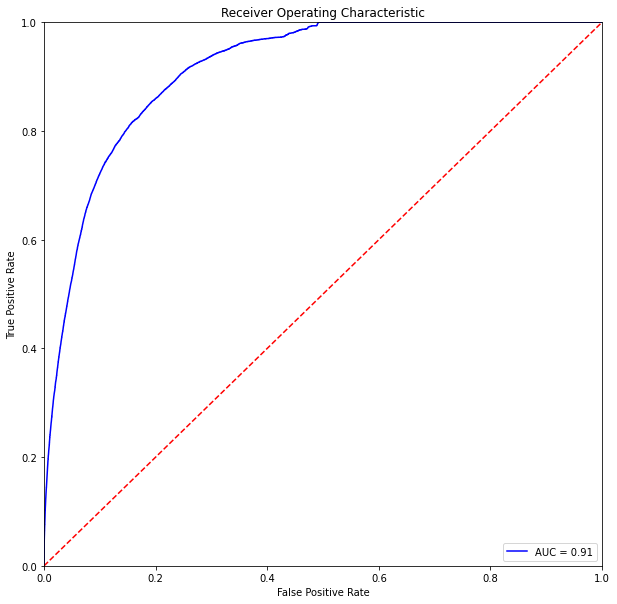

In [148]:
fpr, tpr, threshold = metrics.roc_curve(true_ecod, pred_ecod)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()